In [1]:
import time
import itertools
import numpy as np
from scipy.optimize import minimize, basinhopping
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from modules.utils import *
%matplotlib inline
cmap = plt.get_cmap("plasma") #'viridis'
import qiskit
#%matplotlib inline

In [2]:
print(qiskit.__version__)

0.17.4


In [3]:
#reset random seed
np.random.seed(123)
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 123

In [4]:
### Preliminaries
L = 5
num_trash = 2
logspace_size=50

name = f'VQE_Ising_L5_anti_-1_50x50' # _1e-3   # name of the data produced by this notebook
filename = "data/params_" + name   # name of the data file that is used

In [5]:
L = 5
anti = -1.

VQE_params = np.load(filename + ".npz", allow_pickle=True)
gx_list = VQE_params['gx_list']
gz_list = VQE_params['gz_list']
opt_params = VQE_params['opt_params']

gx_vals = np.unique(gx_list)
gz_vals = np.unique(gz_list)

mag = QMag(L,anti) #magnetization operator (Qiskit)
Smag = Mag(L,anti) #magnetization operator (numpy)
# the ~ is the adjoint, but also it turns the is_measurement attribute to True
~StateFn(mag)
# state is technically a circuit, that prepares the ground state via VQE circuit
#state.draw() # uncomment to see, but is very long

Qen=np.zeros(len(opt_params)); Sen=np.zeros(len(opt_params)) #energies
Qmags=np.zeros(len(opt_params)); Smags=np.zeros(len(opt_params)) #magnetizations

In [6]:
load = True

In [7]:
if load:
    temp = np.load(filename + "_mags-Es.npz",allow_pickle=True)
    Qmags = temp["Qmags"]
    Qen = temp["Qen"]
    Sen = temp["Sen"]
    Smags = temp["Smags"]

In [8]:
if not load:
    for j in range(len(opt_params)):

        gx = gx_list[j]
        gz = gz_list[j]
        H = QHIsing(L, anti, np.float32(gx), np.float32(gz)) # build Hamiltonian Op
        state = init_vqe(opt_params[j], L=L)
        meas_outcome = ~StateFn(mag) @ StateFn(state)

        Qmags[j] = meas_outcome.eval()
        e_outcome = ~StateFn(H) @ StateFn(state)
        Qen[j] = e_outcome.eval()

        init_state, E, ham = ising_groundstate(L, anti, np.float(gx), np.float(gz))
        Sen[j] = E
        Smags[j] = init_state.T.conj()@Smag@init_state #Magnetization with Numpy results
    np.savez(filename + "_mags-Es",Qmags=Qmags, Qen=Qen, Sen=Sen, Smags=Smags) # for large parameter space takes quite a while because of the exact diagonalization

## ED comparison

<ipython-input-9-f3ca36468ff1>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, abs(Smags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
<ipython-input-9-f3ca36468ff1>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)


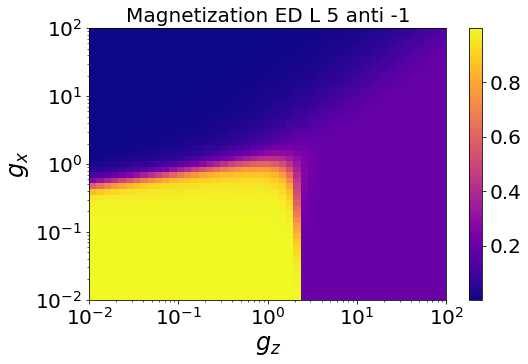

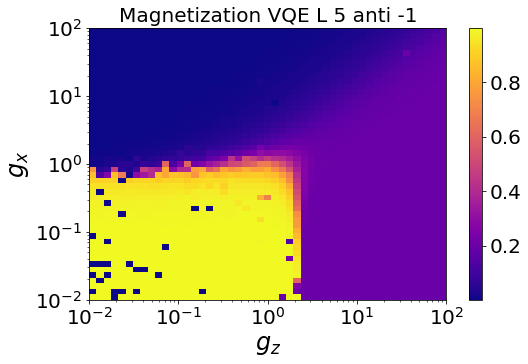

In [9]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Smags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization ED L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

<ipython-input-10-f44c804642c6>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, Sen.reshape(len(gz_vals),len(gx_vals)) - Qen.reshape(len(gz_vals),len(gx_vals)), cmap=cmap)


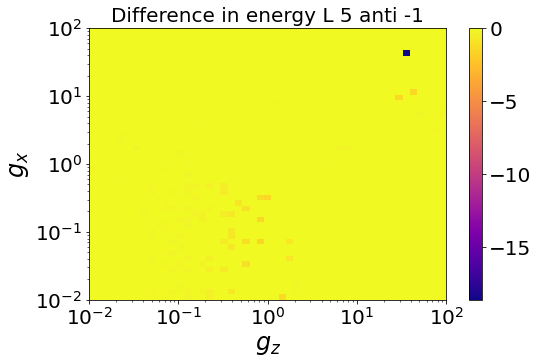

In [10]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, Sen.reshape(len(gz_vals),len(gx_vals)) - Qen.reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Difference in energy L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

In [11]:
##############################################################################
### II - Training  ###########################################################
##############################################################################


# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')


thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [12]:
# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()
    for i in range(num_trash):
        circ.ry(thetas[L-i-1], L-i-1)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash, 'c')
    circ = QuantumCircuit(qreg, creg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = init_vqe(init_state,L=L) + circ
        else:
            circ.initialize(init_state, qreg)
    return circ

In [13]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [14]:
idx = 30
num_trash = 2
J, gx, gz = -1., gx_list[idx], gz_list[idx] # Ising parameters for which ground state should be compressed
phi = opt_params[idx] # train on smallest lambda ;; this may grammatically be confusing, init_state = dictionary with unsorted parameters

def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100):
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots, seed_simulator=123, seed_transpiler=234) # fix seed to make it reproducible

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
run_circuit(thetas, L, num_trash, phi)['11']

<ipython-input-12-a05c1f5c1b9e>:37: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
<ipython-input-12-a05c1f5c1b9e>:43: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = init_vqe(init_state,L=L) + circ
/home/kkottmann/anaconda3/envs/

51

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [15]:
# translate to Rikes naming
phis = opt_params
gxs = gx_list
gzs = gz_list

In [16]:


def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        J, gx, gz = p
        init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None):
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         #learning_rate=1e-1,
                         #perturbation=0.4
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [17]:
x,y = np.meshgrid(gx_vals, gz_vals)

In [18]:
def run_inference(thetas, shots=1000, L=5):
    points = 50
    J = -1.0
    x,y = np.meshgrid(gx_vals, gz_vals)
    cost = np.zeros((len(gx_vals) * len(gz_vals)))
    Smags = np.zeros((len(gx_vals) * len(gz_vals)))
    shots = 1000
    for i,p in enumerate(list(zip(gxs, gzs))):
            cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots)
    cost = cost.reshape((len(gx_vals), len(gz_vals)))
    return cost

cmap = plt.get_cmap("plasma")
def plot_result(cost):
    fig,axs = plt.subplots(ncols=2,figsize=(15,5))
    nbins=100
    ax = axs[0]
    im = ax.pcolormesh(x, y, cost, cmap=cmap, shading="auto")
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"Loss",fontsize=20)
    ax.set_xlabel(r"$g_z$",fontsize=24)
    ax.set_ylabel(r"$g_x$",fontsize=24)
    ax.tick_params(labelsize=20)
    for p in params:
        gz = gz_list[p]
        gx = gx_list[p]
        ax.plot(gz,gx,"o",label="training",color="cyan")
    
    ax = axs[1]
    im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap, shading="auto")
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
    ax.set_xlabel(r"$g_z$",fontsize=24)
    ax.set_ylabel(r"$g_x$",fontsize=24)
    ax.tick_params(labelsize=20)

## Training on bottom-left

In [19]:
paramss =[
    [0], # train on bottom left point
    np.intersect1d(np.where(gx_list > 99),np.where(gz_list == 1e-2)), # top left
    np.intersect1d(np.where(gz_list > 99),np.where(gx_list == 1e-2)), # bottom right
    [2450, 49] # both paramagnetic phases
]

In [20]:
for i,params in enumerate(paramss):
    print(f"{i} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")

0 / 4 - params (gz, gx) in [(0.01, 0.01)]
1 / 4 - params (gz, gx) in [(0.01, 100.0)]
2 / 4 - params (gz, gx) in [(100.0, 0.01)]
3 / 4 - params (gz, gx) in [(0.01, 100.0), (100.0, 0.01)]


In [21]:
thetass = [None] * len(paramss)
losss = [None] * len(paramss)
costs = [None] * len(paramss)

## Run 1

1 / 4 - params (gz, gx) in [(0.01, 0.01)]
Initial cost: 0.868
Time: 23.87807 sec
(array([ 0.82476645, -3.1453638 ,  0.68788485,  3.11009066,  1.69271055,
        2.33240648,  4.87630123,  5.59706283,  3.1833242 ,  2.89241369,
        5.09311531,  3.30815259]), 0.003, 300)
2 / 4 - params (gz, gx) in [(0.01, 100.0)]
Initial cost: 1.336
Time: 24.78457 sec
(array([ 2.71103252,  1.57116567,  3.96802967,  1.45018592,  0.10674416,
        5.27915628,  3.15402666,  2.87838626,  1.73606837,  4.59733132,
        2.72449908, -0.10956637]), 0.005, 300)
3 / 4 - params (gz, gx) in [(100.0, 0.01)]
Initial cost: 0.416
Time: 25.75921 sec
(array([4.07750984e+00, 5.05996014e+00, 5.95478968e+00, 3.23212747e+00,
       3.13979475e+00, 1.98065957e+00, 1.79888603e+00, 1.73700474e+00,
       6.11840616e+00, 3.19586720e-03, 2.61367028e+00, 5.63534713e+00]), 0.002, 300)
4 / 4 - params (gz, gx) in [(0.01, 100.0), (100.0, 0.01)]
Initial cost: 0.998
Time: 50.67833 sec
(array([3.73178144, 5.03911597, 0.12975903, 5.

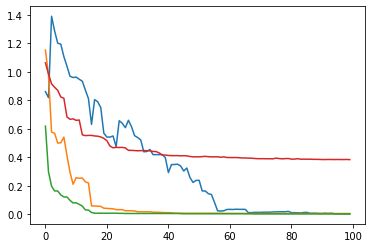

In [22]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    thetas, loss, accepted = optimize(params, max_iter=100, L=5) #, pick_optimizer="adam")
    thetass[i], losss[i] = thetas, loss
    plt.plot(loss)
    cost = run_inference(thetas)
    costs[i] = cost

In [23]:
np.savez("data/" + name + "_thetas-loss-cost", losss = losss, costs = costs, thetass = thetass)

1 / 4 - params (gz, gx) in [(0.01, 0.01)]


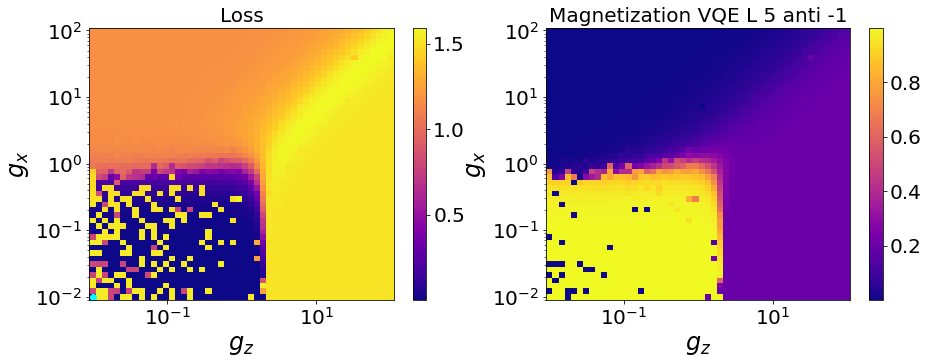

2 / 4 - params (gz, gx) in [(0.01, 100.0)]


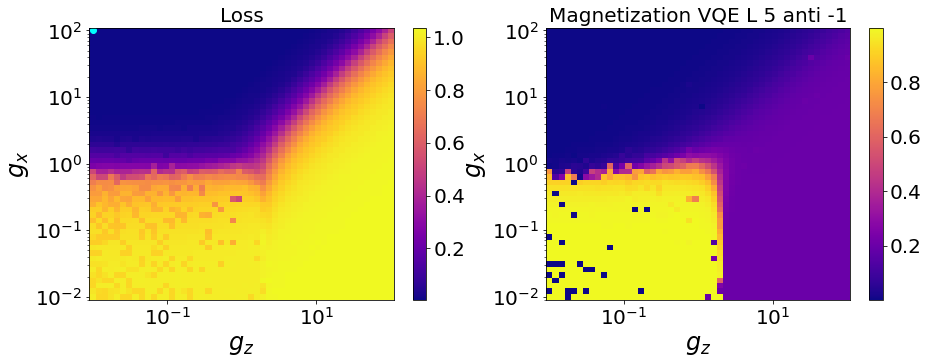

3 / 4 - params (gz, gx) in [(100.0, 0.01)]


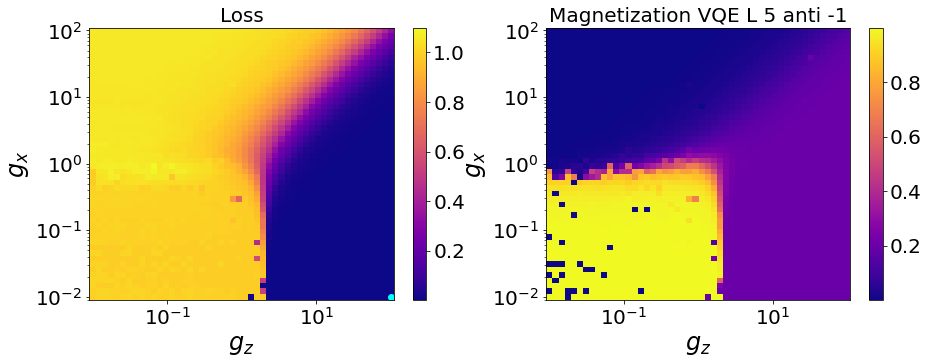

4 / 4 - params (gz, gx) in [(0.01, 100.0), (100.0, 0.01)]


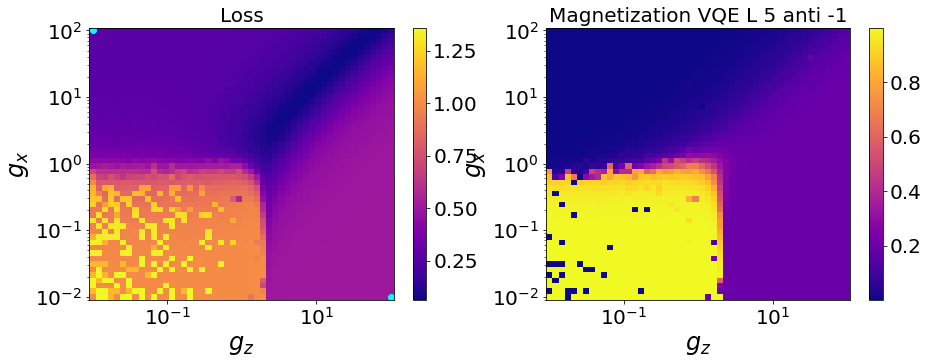

In [22]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    plot_result(np.load("data/" + name + "_thetas-loss-cost.npz",allow_pickle=True)["costs"][i])
    plt.show()

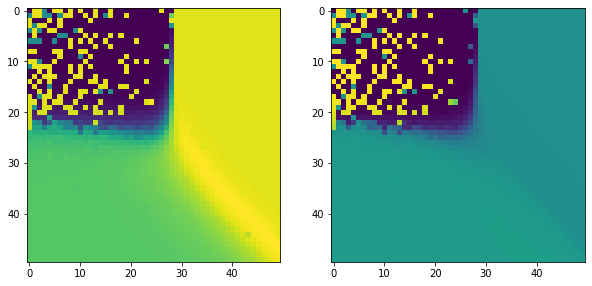

In [23]:
fig, axs = plt.subplots(ncols=2,figsize=(10,5))
ax = axs[0]
ax.imshow(np.load("data/" + name + "_thetas-loss-cost.npz",allow_pickle=True)["costs"][0])

ax = axs[1]
ax.imshow(np.load("data/" + name + "_thetas-loss-cost2.npz",allow_pickle=True)["costs"][0])



## Run 2

In [25]:
algorithm_globals.random_seed = 321

1 / 4 - params (gz, gx) in [(0.01, 0.01)]
Initial cost: 1.310
Time: 28.02888 sec
(array([2.57692685, 2.95755801, 4.26913311, 3.17826106, 3.37086634,
       0.02133483, 2.88315746, 2.12779927, 3.08234931, 5.81963113,
       0.2729585 , 5.03568803]), 0.005, 300)
2 / 4 - params (gz, gx) in [(0.01, 100.0)]
Initial cost: 0.772
Time: 29.22060 sec
(array([ 4.4216605 ,  7.10729005,  0.96697932,  4.8174139 ,  2.52032331,
       -2.21613273,  2.44420466,  7.30765602,  4.66658582,  6.94940965,
        4.37194079,  3.15342457]), 0.178, 300)
3 / 4 - params (gz, gx) in [(100.0, 0.01)]
Initial cost: 1.280
Time: 28.51438 sec
(array([6.29171700e+00, 4.65401334e+00, 3.14485115e+00, 1.39314264e+00,
       1.20950499e-03, 2.77420937e+00, 4.76928257e+00, 6.82884743e+00,
       2.78850870e+00, 6.28623856e+00, 5.98896647e+00, 4.04957841e+00]), 0.0, 300)
4 / 4 - params (gz, gx) in [(0.01, 100.0), (100.0, 0.01)]
Initial cost: 1.074
Time: 55.65328 sec
(array([1.92045541, 3.6132162 , 0.52282624, 2.560647  , 2.88

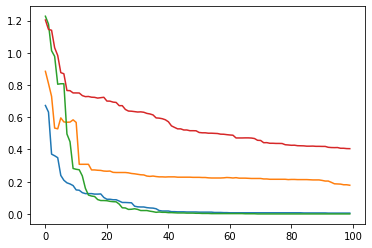

In [26]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    thetas, loss, accepted = optimize(params, max_iter=100, L=5) #, pick_optimizer="adam")
    thetass[i], losss[i] = thetas, loss
    plt.plot(loss)
    cost = run_inference(thetas)
    costs[i] = cost

In [27]:
np.savez("data/" + name + "_thetas-loss-cost2", losss = losss, costs = costs, thetass = thetass)

1 / 4 - params (gz, gx) in [(0.01, 0.01)]


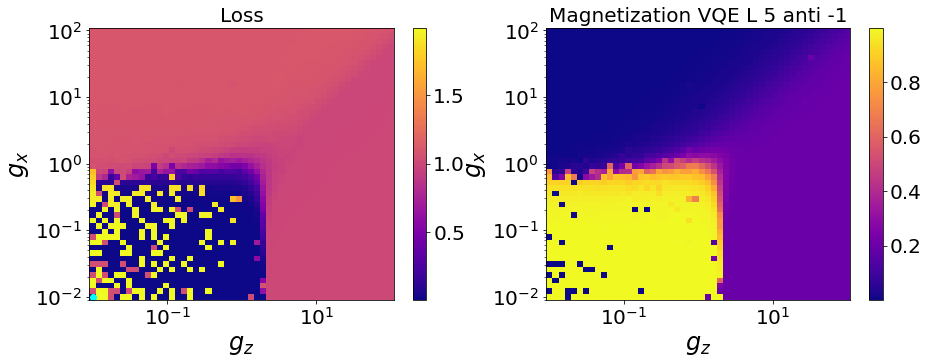

2 / 4 - params (gz, gx) in [(0.01, 100.0)]


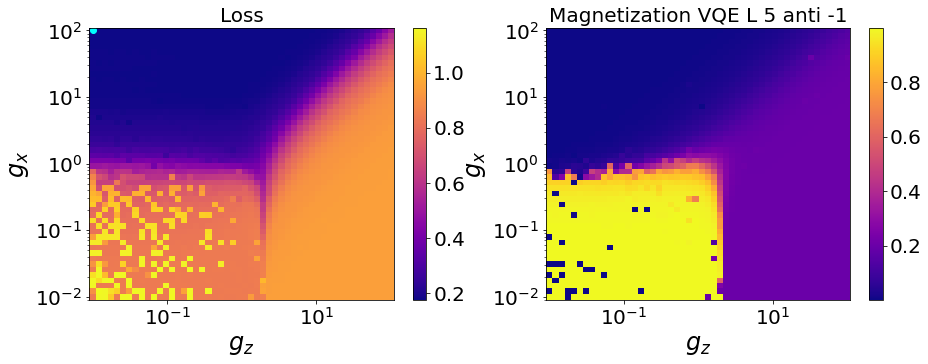

3 / 4 - params (gz, gx) in [(100.0, 0.01)]


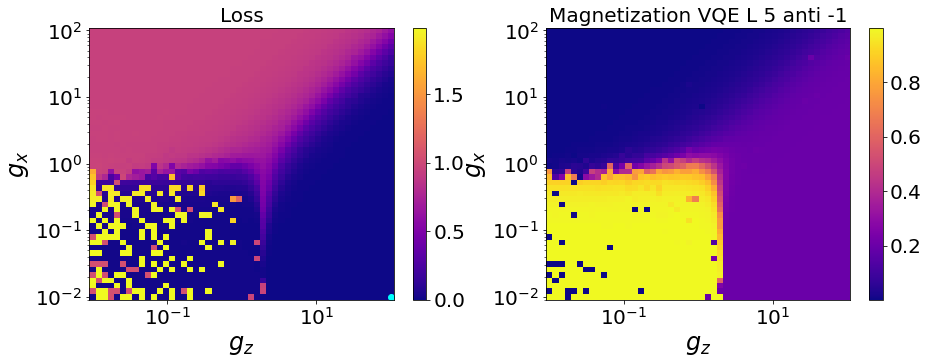

4 / 4 - params (gz, gx) in [(0.01, 100.0), (100.0, 0.01)]


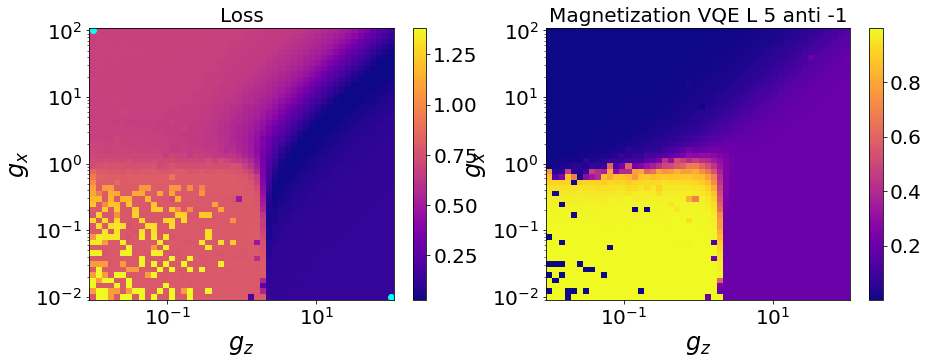

In [28]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    plot_result(np.load("data/" + name + "_thetas-loss-cost2.npz",allow_pickle=True)["costs"][i])
    plt.show()

## Run 3 COBYLA

1 / 4 - params (gz, gx) in [(0.01, 0.01)]
Initial cost: 0.961
Time: 8.59617 sec
(array([ 4.70963501,  3.21954408,  2.78927419,  3.17809115,  0.95628964,
        4.68690794,  3.59145994,  3.44825983,  3.16877727,  4.34406668,
       -0.21445253,  5.80032095]), 0.002, 100)
2 / 4 - params (gz, gx) in [(0.01, 100.0)]
Initial cost: 1.176
Time: 8.22399 sec
(array([7.57773888, 1.61209778, 1.51288191, 4.8412338 , 6.37124707,
       7.60944171, 0.06608074, 4.50591196, 4.88435404, 1.70525221,
       4.55017455, 1.13483579]), 0.007, 100)
3 / 4 - params (gz, gx) in [(100.0, 0.01)]
Initial cost: 0.876
Time: 7.86374 sec
(array([3.71112554, 6.31966205, 7.20264829, 0.04314051, 2.47441117,
       2.48384028, 3.89137594, 5.07925535, 0.02436728, 1.3535261 ,
       5.43618114, 3.32903792]), 0.007, 100)
4 / 4 - params (gz, gx) in [(0.01, 100.0), (100.0, 0.01)]
Initial cost: 1.027
Time: 16.83720 sec
(array([ 2.18075085,  3.301306  ,  3.4859337 , -0.59235482,  4.21109175,
        4.89083879,  2.61890788,  5.

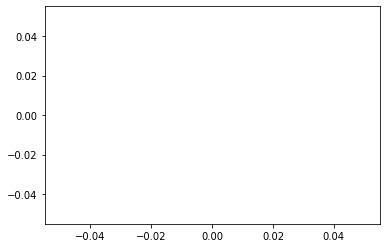

In [29]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    thetas, loss, accepted = optimize(params, max_iter=100, L=5, pick_optimizer="cobyla")
    thetass[i], losss[i] = thetas, loss
    plt.plot(loss)
    cost = run_inference(thetas)
    costs[i] = cost

In [30]:
np.savez("data/" + name + "_thetas-loss-cost_cobyla", losss = losss, costs = costs, thetass = thetass)

1 / 4 - params (gz, gx) in [(0.01, 0.01)]


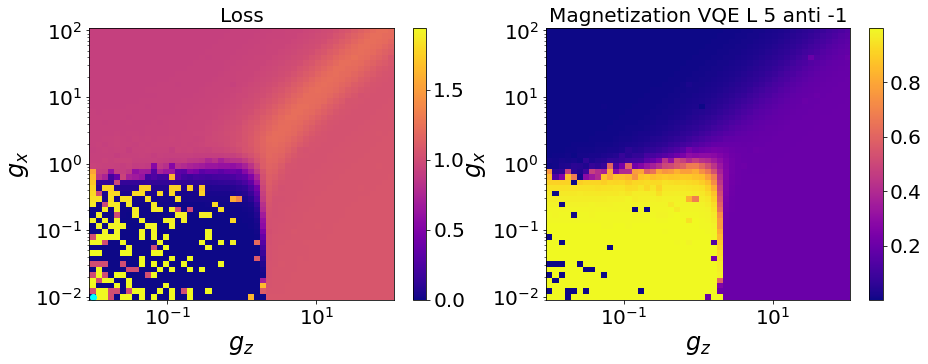

2 / 4 - params (gz, gx) in [(0.01, 100.0)]


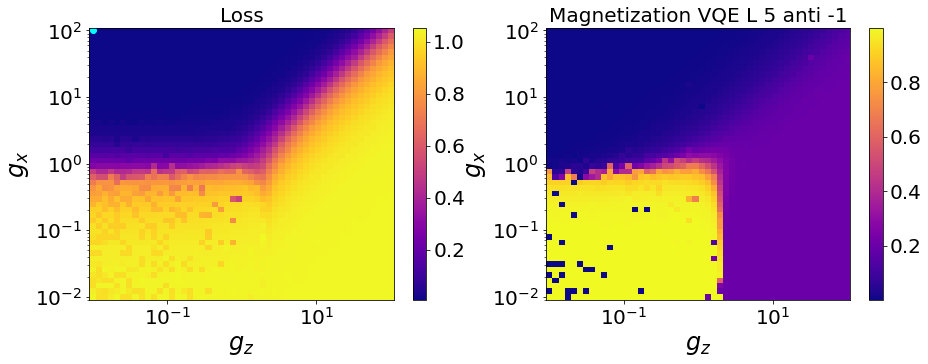

3 / 4 - params (gz, gx) in [(100.0, 0.01)]


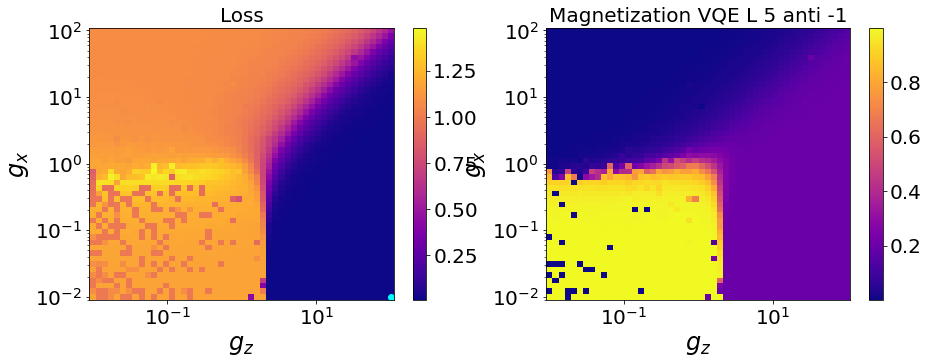

4 / 4 - params (gz, gx) in [(0.01, 100.0), (100.0, 0.01)]


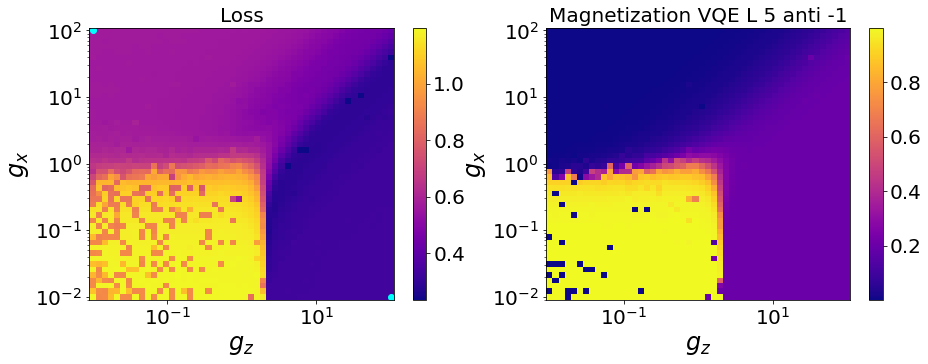

In [31]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    plot_result(np.load("data/" + name + "_thetas-loss-cost_cobyla.npz",allow_pickle=True)["costs"][i])
    plt.show()